In [1]:
import json

# Path to the dataset
train_file_path = "train.json"

def flatten_evidence(evidence):
    flattened = []
    for item in evidence:
        try:
            while isinstance(item[0], list):
                item = item[0]
            for evidence_item in item:
                flattened.append(evidence_item)
        except:
            continue
    return flattened

def load_strategyqa_train_data(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    train_data = []
    for item in data:
        parsed_entry = {
            "id": item.get("qid", ""),
            "term": item.get("term", ""),
            "description": item.get("description", ""),
            "question": item["question"],
            "answer": item["answer"],
            "facts": item.get("facts", []),
            "decomposition": item.get("decomposition", []),
            "evidence": flatten_evidence(item.get("evidence", []))
        }
        train_data.append(parsed_entry)
    return train_data

train_data = load_strategyqa_train_data(train_file_path)
print(json.dumps(train_data[:2], indent=4))
print(len(train_data))


[
    {
        "id": "2bc9c4f9c19c167187f2",
        "term": "Genghis Khan",
        "description": "founder and first Great Khan of the Mongol Empire",
        "question": "Are more people today related to Genghis Khan than Julius Caesar?",
        "answer": true,
        "facts": [
            "Julius Caesar had three children.",
            "Genghis Khan had sixteen children.",
            "Modern geneticists have determined that  out of every 200 men today has DNA that can be traced to Genghis Khan."
        ],
        "decomposition": [
            "How many kids did Julius Caesar have?",
            "How many kids did Genghis Khan have?",
            "Is #2 greater than #1?"
        ],
        "evidence": [
            "Caesarion-2",
            "Julia (daughter of Caesar)-1",
            "Julius Caesar-75",
            "Gaius Julius Caesar-7"
        ]
    },
    {
        "id": "03caf265939fab701dee",
        "term": "The Police",
        "description": "English rock band",
  

In [2]:
from transformers import T5Tokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Use the T5-small public model
tokenizer = T5Tokenizer.from_pretrained("t5-small", add_prefix_space=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

class QuestionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        # Add a special token to separate decomposition and evidence
        self.sep_token = "[SEP]"
        if self.sep_token not in self.tokenizer.get_vocab():
            self.tokenizer.add_tokens([self.sep_token])
            self.tokenizer.model_max_length = self.max_len
            self.tokenizer.init_kwargs['model_max_length'] = self.max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        id = item['id']
        question = item["question"]
        term = item["term"]
        description = item["description"]
        facts = " ".join(item["facts"])
        decomposition = item["decomposition"]
        evidence = item["evidence"]

        # Combine inputs (question, term, description, facts)
        combined_input = f"{question} {term} {description} {facts}"

        # Tokenize the input text
        encoding = self.tokenizer(
            combined_input,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Binary answer label (for classification)
        answer_label = 1 if item["answer"] else 0
        answer_label = torch.tensor(answer_label, dtype=torch.float)

        # Concatenate decomposition and evidence into a single label string
        label = ""
        for d in decomposition:
            label += d + " "
        label += self.sep_token
        for e in evidence:
            label += "|" + e

        # Tokenize the label (plain string, so no is_split_into_words flag)
        combined_labels = self.tokenizer(
            label,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )["input_ids"].squeeze(0)

        vocab_size = len(self.tokenizer)
        if (combined_labels >= vocab_size).any():
            raise ValueError(f"Invalid label value found. Label values must be less than {vocab_size}.")

        return {
            "id": id,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "answer_label": answer_label,
            "labels": combined_labels
        }

train_dataset = QuestionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
# Verify label decoding
print(tokenizer.decode(next(iter(train_loader))["labels"][0], skip_special_tokens=True))
print(next(iter(train_loader))["labels"][0].shape)

# Load validation data
val_data = 'dev.json'
val_data = load_strategyqa_train_data(val_data)
val_dataset = QuestionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
print(len(val_dataset))


What was the top speed of Hurricane Harvey? What is the top speed of a Peregrine falcon? Is #1 greater than #2? [SEP] |Hurricane Harvey-24|Hurricane Harvey-5|Hurricane Harvey-6
torch.Size([512])
229


In [4]:
import torch
import torch.nn as nn
from transformers import T5ForConditionalGeneration, T5Tokenizer

class T5MultiTaskWrapper(nn.Module):
    def __init__(self, model_name="t5-small", max_len=512):
        super(T5MultiTaskWrapper, self).__init__()
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        self.tokenizer = T5Tokenizer.from_pretrained(model_name, add_prefix_space=True)
        self.max_len = max_len

        # Add a special separator token if not present
        self.sep_token = "[SEP]"
        if self.sep_token not in self.tokenizer.get_vocab():
            self.tokenizer.add_tokens([self.sep_token])
            self.t5.resize_token_embeddings(len(self.tokenizer))

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Classification head using the encoder's hidden state
        self.fc1 = nn.Linear(self.t5.config.d_model, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward_generate(self, input_ids, attention_mask):
        # For generation training, compute logits using the model’s forward pass.
        # Here, we pass labels equal to the input_ids (for demonstration), but in practice you would use your proper targets.
        outputs = self.t5(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        return outputs.logits

    def forward_classify(self, input_ids, attention_mask):
        # Use the encoder outputs for classification.
        encoder_outputs = self.t5.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Average pooling over the sequence length
        pooled = encoder_outputs.last_hidden_state.mean(dim=1)
        fc1_output = self.relu(self.fc1(pooled))
        fc2_output = self.sigmoid(self.fc2(fc1_output))
        return None, fc2_output  # Generation output is not used for classification

    def generate(self, input_ids, attention_mask, max_new_tokens=128):
        generated_ids = self.t5.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_new_tokens,
            num_return_sequences=1
        )
        return self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)


2025-03-18 06:24:23.175144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 06:24:23.175197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 06:24:23.176445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 06:24:23.184084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from sklearn.metrics import accuracy_score

def train_generation(model, dataloader, optimizer, device, epochs=3):
    """
    Train the model on the generation task.
    """
    # Ensure T5 parameters are trainable
    for param in model.t5.parameters():
        param.requires_grad = True
    # Freeze the classification head during generation training
    for param in model.fc1.parameters():
        param.requires_grad = False
    for param in model.fc2.parameters():
        param.requires_grad = False

    model.train()
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            logits = model.forward_generate(input_ids, attention_mask)
            loss = nn.CrossEntropyLoss()(
                logits.view(-1, logits.size(-1)),
                labels.view(-1)
            )
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss}")
    return train_losses

def train_classification(model, train_dataloader, val_dataloader, optimizer, device, epochs=3):
    """
    Train the model on the classification task.
    """
    # Freeze T5 parameters during classification training
    for param in model.t5.parameters():
        param.requires_grad = False
    # Ensure classification head is trainable
    for param in model.fc1.parameters():
        param.requires_grad = True
    for param in model.fc2.parameters():
        param.requires_grad = True

    model.train()
    train_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        all_preds = []
        all_labels = []
        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            answer_labels = batch["answer_label"].to(device)
            optimizer.zero_grad()
            _, classify_outputs = model.forward_classify(input_ids, attention_mask)
            loss = nn.BCELoss()(classify_outputs.squeeze(), answer_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            preds = (classify_outputs.squeeze() > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(answer_labels.cpu().numpy())
        train_acc = accuracy_score(all_labels, all_preds)
        train_accs.append(train_acc)
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_epoch_loss)
        val_acc = evaluate(model, val_dataloader, device)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}")
    return train_losses, train_accs, val_accs

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            answer_labels = batch["answer_label"].to(device)
            _, classify_outputs = model.forward_classify(input_ids, attention_mask)
            preds = (classify_outputs.squeeze() > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(answer_labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)


In [6]:
from torch.optim import AdamW
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = T5MultiTaskWrapper(model_name="t5-small")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)


cuda


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/15, Loss: 2.776562574297883
Epoch 2/15, Loss: 0.9954572874446248
Epoch 3/15, Loss: 0.8858858707339264
Epoch 4/15, Loss: 0.8286250499329826
Epoch 5/15, Loss: 0.7952298859293147
Epoch 6/15, Loss: 0.7727256364138552
Epoch 7/15, Loss: 0.757822035819061
Epoch 8/15, Loss: 0.7447189725646677
Epoch 9/15, Loss: 0.7351257057152978
Epoch 10/15, Loss: 0.7280812025532242
Epoch 11/15, Loss: 0.7175141353477803
Epoch 12/15, Loss: 0.7111768798772679
Epoch 13/15, Loss: 0.7033440385215967
Epoch 14/15, Loss: 0.6968729368938033
Epoch 15/15, Loss: 0.6905795760857042


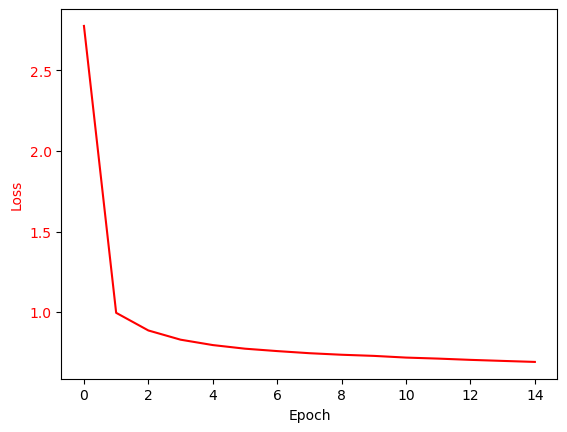

Epoch 1/5, Loss: 0.6919966818288316, Train Acc: 0.5245026686074721, Val Acc: 0.5327510917030568
Epoch 2/5, Loss: 0.6904666636341302, Train Acc: 0.532265890344493, Val Acc: 0.5327510917030568
Epoch 3/5, Loss: 0.6894027207248895, Train Acc: 0.532265890344493, Val Acc: 0.5327510917030568
Epoch 4/5, Loss: 0.6885088208571885, Train Acc: 0.532265890344493, Val Acc: 0.5327510917030568
Epoch 5/5, Loss: 0.6876145640546961, Train Acc: 0.532265890344493, Val Acc: 0.5327510917030568


In [7]:
import gc
import matplotlib.pyplot as plt
gc.collect()
torch.cuda.empty_cache()

# Train generation task
train_losses_generation = train_generation(model, train_loader, optimizer, device, epochs=15)

def plot_gen(losses):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='red')
    ax1.plot(losses, color='red', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='red')
    plt.show()

plot_gen(train_losses_generation)

# Train classification task
train_losses, train_accs, val_accs = train_classification(model, train_loader, val_loader, optimizer, device, epochs=5)


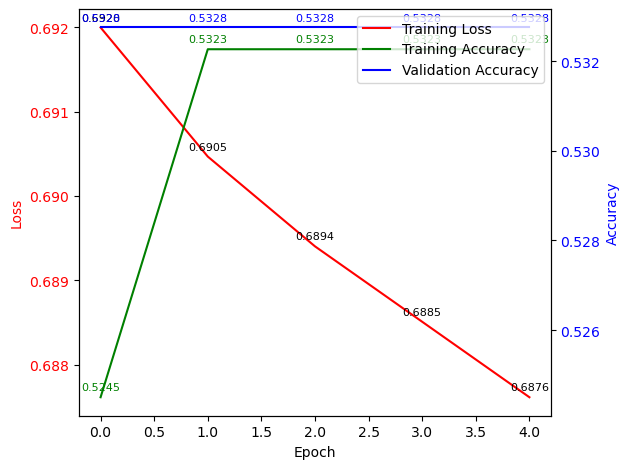

In [8]:
import matplotlib.pyplot as plt
def plot_results(losses, train_accs, val_accs):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='red')
    ax1.plot(losses, color='red', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='red')
    for i, loss in enumerate(losses):
        ax1.annotate(f'{loss:.4f}', (i, loss), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='blue')
    ax2.plot(train_accs, color='green', label='Training Accuracy')
    ax2.plot(val_accs, color='blue', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='blue')
    for i, t_acc, v_acc in zip(range(len(train_accs)), train_accs, val_accs):
        ax2.annotate(f'{t_acc:.4f}', (i, t_acc), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='green')
        ax2.annotate(f'{v_acc:.4f}', (i, v_acc), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

plot_results(train_losses, train_accs, val_accs)


In [9]:
a = next(iter(val_loader))
model.eval()
with torch.no_grad():
    input_ids = a["input_ids"].to(device)
    attention_mask = a["attention_mask"].to(device)
    labels = a["answer_label"].to(device)
    _, outputs = model.forward_classify(input_ids, attention_mask)
    print(outputs.shape)
    predicted = (outputs > 0.5).float()
    print(predicted, labels)


torch.Size([8, 1])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0') tensor([0., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0')


In [10]:
gen = model.forward_generate(input_ids, attention_mask)
label = a['labels'].to(device)
loss = nn.CrossEntropyLoss()(gen.view(-1, gen.size(-1)), label.view(-1))
print(loss)
print(model.generate(input_ids, attention_mask, 10))


tensor(0.7124, device='cuda:0')
['What many of Albany Albany Albany Albany Albany Albany', 'What language language of the the in in in', 'What are the the thes of of of', 'What is the the the the the the the', 'What was the the the the #1 #1 #1', 'What is the the the the Miami Miami Miami', 'What is the the the the the of the', 'What was was the the the Colonial Colonial Colonial']


In [11]:
def compile_output(model, dataloader, tokenizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    predictions = {}
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            item_ids = batch['id']
            generated_text = model.generate(input_ids, attention_mask)
            for i, item_id in enumerate(item_ids):
                label_text = generated_text[i]
                if tokenizer.sep_token not in label_text:
                    print('SEP not in generated text')
                    continue
                decomposition_text, paragraph_text = label_text.split(tokenizer.sep_token)
                decomposition_text = decomposition_text.strip()
                paragraph_text = paragraph_text.replace(tokenizer.eos_token, "").strip().rstrip()
                decomposition_list = [q.strip() for q in decomposition_text.split("?") if q.strip()]
                decomposition_list = [q + "?" for q in decomposition_list]
                paragraph_list = [p.strip() for p in paragraph_text.split("|") if p.strip()]
                predictions[item_id] = {
                    "decomposition": decomposition_list,
                    "paragraphs": paragraph_list
                }
    return predictions


In [12]:
d = val_data[:3]
dd = QuestionDataset(d, tokenizer)
dloader = DataLoader(dd, batch_size=8, shuffle=False)
for batch in dloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    item_ids = batch['id']
    generated_text = model.generate(input_ids, attention_mask)
    for i, item_id in enumerate(item_ids):
        label_text = generated_text[i]
        print(label_text)
        decomposition_text, paragraph_text = label_text.split(tokenizer.sep_token)
        decomposition_text = decomposition_text.strip()
        paragraph_text = paragraph_text.replace(tokenizer.eos_token, "").strip().rstrip()
        decomposition_list = [q.strip() for q in decomposition_text.split("?") if q.strip()]
        decomposition_list = [q + "?" for q in decomposition_list]
        paragraph_list = [p.strip() for p in paragraph_text.split("|") if p.strip()]
        print(decomposition_list)
        print(paragraph_list)


What many of Albany Albany Albany Albany Albany Albany Albany Albany Albany Albany Albany Albany Albany Albany????????????????????????????????????????????????????????????????????????????????????????????????? of of of Albany Albany Albany Albany Albany Albany Albany Albany Albany Albany


ValueError: too many values to unpack (expected 2)